In [1]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
import sklearn.linear_model
π = np.pi

# Climate dataset challenge

* What is the rate of temperature increase in Cambridge?
* Are temperatures increasing at a constant rate, or has the increase accelerated?
* How do results compare across the whole of the UK?

**Your task is to answer these questions using appropriate linear models, and to produce elegant plots to communicate your findings.
Please submit a Jupyter notebook, or a pdf, on [Moodle](https://www.cl.cam.ac.uk/teaching/current/DataSci/redirect/climatemoodle.html). Include explanations of what your models are, and of what your plots show.**

The dataset is from [https://www.metoffice.gov.uk/pub/data/weather/uk/climate/](https://www.metoffice.gov.uk/pub/data/weather/uk/climate/). Code for retrieving the dataset is given at the bottom.

In [ ]:
url = 'https://www.cl.cam.ac.uk/teaching/current/DataSci/data/climate_202510.csv'
climate = pandas.read_csv(url)
# Or run the scraping code at the bottom
# (Warning: the scraping code may break if the Met Office changes its webpages. If it breaks,
# just use the csv above.)

# Define two extra covariates
climate['t'] = climate.yyyy + (climate.mm-1)/12    # timestamp in years
climate['temp'] = (climate.tmin + climate.tmax)/2  # monthly avg temp

## Fitting a linear model

To illustrate fitting a linear model (see section 2 of the course), we'll fit a simple periodic model:
$$
Y_i \sim \alpha + \beta_1 \sin(2\pi t_i) + \beta_2 \cos(2\pi t_i) + \operatorname{Normal}(0,\sigma^2)
$$

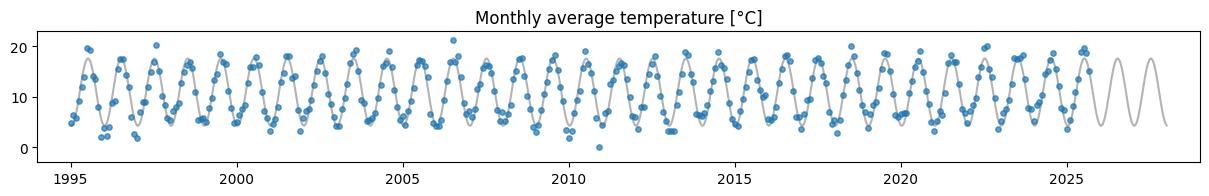

In [12]:
# Restrict attention to Cambridge, 1995 onwards, for illustration
df = climate.loc[(climate.station=='Cambridge') & (climate.yyyy>=1995)]

X = np.column_stack([np.sin(2*π*df.t), np.cos(2*π*df.t)])
model = sklearn.linear_model.LinearRegression()
model.fit(X, df.temp)
α,(β1,β2) = (model.intercept_, model.coef_)

# Plot a curve to depict the fitted values
tnew = np.linspace(1995, 2028, 1000)
Xnew = np.column_stack([np.sin(2*π*tnew), np.cos(2*π*tnew)])
temp_pred = model.predict(Xnew)

fig,ax = plt.subplots(figsize=(15,1.7))
ax.scatter(df.t, df.temp, s=15, alpha=0.7)
ax.plot(tnew, temp_pred, color='0.7', zorder=0)
ax.set_xlim([1994,2029])
ax.set_ylim([-3,23])
ax.set_title('Monthly average temperature [°C]')

plt.show()

### Plotting the residuals

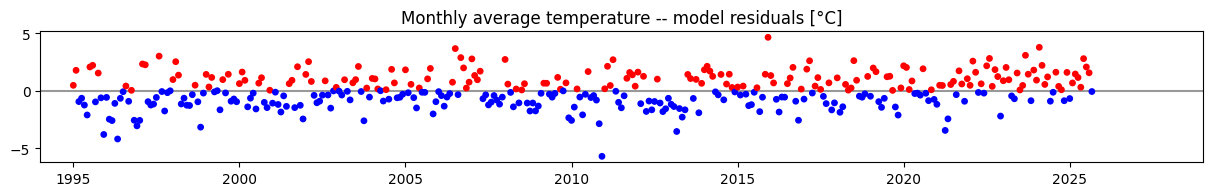

In [13]:
resid = df.temp - model.predict(X)

fig,ax = plt.subplots(figsize=(15,1.7))
ax.scatter(df.t, resid, c=np.where(resid<=0,'blue','red'), s=15)
ax.axhline(0, color='0.6', zorder=0)
ax.set_xlim([1994,2029])
ax.set_title('Monthly average temperature -- model residuals [°C]')
plt.show()

# Appendix: retrieving the dataset

In [8]:
import numpy as np
import pandas
import requests, requests_cache
import urllib
import io, re
import lxml.html
import numbers
requests_cache.install_cache(backend='memory')

In [9]:
# Fetch a list of all measurement stations
stations_url = 'https://www.metoffice.gov.uk/research/climate/maps-and-data/historic-station-data'
stations = requests.get(stations_url).content
stations = lxml.html.fromstring(stations)
stations = stations.xpath("//h2[contains(text(),'List of all the historic stations')]/following-sibling::table/tbody/tr")
stations = [tr.xpath('./td/a/@href')[0] for tr in stations]

In [10]:
# Fetch historical data from each station
def parse_station_data(txt, i=None):
    ls = txt.splitlines()
    g = (i for i,l in enumerate(ls) if ' '.join(l.split()).startswith('yyyy mm tmax tmin'))
    header_line = next(g)
    d = '\n'.join([ls[header_line]+' status X1 X2 X3 X4 X5 X6'] + ls[(header_line+2):])
    df = pandas.read_csv(io.StringIO(d), delim_whitespace=True)
    df['station'] = [ls[0]] * len(df)
    s = ls[1] + ' ' + ls[2]
    m = re.search(r'Lat ([-\d.]+) Lon ([-\d.]+),? ([-\d.]+)\s?m.* amsl', s)
    assert m is not None, f"Can't read details for {i}: {s}"
    df['lat'] = [m.group(1)] * len(df)
    df['lng'] = [m.group(2)] * len(df)
    df['height'] = [m.group(3)] * len(df)
    return df
df = [requests.get(station_url).content.decode('utf8') for station_url in stations]
df = [parse_station_data(txt,i) for i,txt in enumerate(df)]

# Concatenate all the station together
df = pandas.concat(df, ignore_index=True)
# Sometimes there are comment rows, and df.yyy is string
# Sometimes there are no comment rows, and df.yyy is int
# This code removes any comment rows, safely in either case
df = df.loc[df.yyyy.astype(str) != 'Site']

# Delete some dummy columns (which were only there for rows with comments)
for i in range(1,7): del df[f'X{i}']

# Normalize some long-winded station names
for old,new in [('Heathrow (London Airport)','Heathrow'), 
                ('Lowestoft / Lowestoft Monckton Ave from Sept 2007','Lowestoft'),
                ('Whitby Coastguard / Whitby(from 2000 and $sunshine)','Whitby'),
                ('Nairn   there is a site change in 1998','Nairn'),
                ('Cambridge NIAB','Cambridge')]:
    df['station'] = np.where(df['station']==old, new, df['station'])
    
# Tidy the numerical columns, to only have numbers or NaN
def clean_num(x):
    if isinstance(x, numbers.Number):
        return x
    elif x == '---':
        return np.nan
    else:
        return float(re.match(r'([-\d.]+)', x).group(1))
df['tmin'] = np.array([clean_num(x) for x in df['tmin']])
df['tmax'] = np.array([clean_num(x) for x in df['tmax']])
df['yyyy'] = np.array([clean_num(x) for x in df['yyyy']]).astype(int)
df['mm'] = np.array([clean_num(x) for x in df['mm']]).astype(int)

climate = df